# **MONTE CARLO SIMULATIONS**

# *Muhammad Umar IJAZ*

# **STEP 1**: Preparing the workplace.

First what we'll do:
1.  **Import Libraries:** Pandas, numpy, matplotlib, pathlib
2.  **Upload the Excel File:**

In [20]:
# STEP 1: SETUP AND FILE UPLOAD
# Import necessary libraries and handle the file upload in the Colab environment.

from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# This block will prompt for a file upload when run in Google Colab.
try:
    uploaded = files.upload()
    # Automatically get the filename of the uploaded file
    EXCEL_PATH = next(iter(uploaded))
    print(f"Successfully loaded: {EXCEL_PATH}")
except (NameError, StopIteration):
    # This is a fallback for running outside of Colab.

    EXCEL_PATH = "Monte Carlo simulations.xlsx"
    print(f"Running in a non-Colab environment. Assuming file is at: {EXCEL_PATH}")

Saving Monte Carlo Test-.xlsx to Monte Carlo Test- (2).xlsx
Successfully loaded: Monte Carlo Test- (2).xlsx


# **STEP 2**: Defining the Simulation parameters "


We wanted to run the simulation with 1000 showers

All the values here are taken directly from the **Assumptions and Data sections** of the instructions provided in the Excel file.

In [21]:
# All key parameters for the simulation are defined here.

N_SIMULATIONS   = 1000                          # Number of simulations to run

# By setting a "random seed," we make our "random" numbers predictable.
RANDOM_SEED     = 42                            # Seed for reproducibility

# Shower Parameters

SHOWER_MEAN_MIN = 10.0      # Mean shower length in minutes
SHOWER_SD_MIN   = 3.0       # Standard deviation of shower length in minutes
FLOW_RATE_GPM   = 2.5       # Shower flow rate in gallons per minute

# Conversion & Energy Constants
GALLON_TO_LITER          = 3.785                 # Conversion factor for gallons to liters
HEAT_ENERGY_PER_LITER_MJ = 0.144                 # Heat energy required per liter of water (MJ)

# **STEP 3**: Data Loading and Cleaning

This step focuses on extracting and preparing the required data from the uploaded Excel file.

In [22]:
# This section handles all data extraction and preparation from the Excel file. It cleanly separates the data preparation task from the simulation logic.

def load_and_clean_data(excel_path):

    xls = pd.ExcelFile(excel_path)
    df  = pd.read_excel(xls, sheet_name="instructions+data", header=None)


    # Extract Heat EF Table

    # Finding the header row for the Heat table.
    heat_header_idx = None
    for i in range(len(df) - 1):
        if str(df.iloc[i, 0]).strip() == "Name" and "ecoinvent" in str(df.iloc[i, 1]):
            heat_header_idx = i
            break

    # Now we read the table data based on the found header.
    heat_headers = df.iloc[heat_header_idx, :8].astype(str).tolist()
    rows = []
    i = heat_header_idx + 1
    while i < len(df):
        row = df.iloc[i, :8]
        if pd.isna(row).all(): break
        rows.append(row.tolist()); i += 1

    # Creating and cleaning the Heat DataFrame
    heat_all = pd.DataFrame(rows, columns=heat_headers)
    heat_df = heat_all[heat_all["Name"].astype(str).str.contains("Heat|Electricity|Share", na=False)].copy()
    for col in ["Proportion", "CO2"]:
        heat_df[col] = pd.to_numeric(heat_df[col], errors="coerce")
    heat_df = heat_df.dropna(subset=["Proportion", "CO2"])[["Name", "Proportion", "CO2"]].reset_index(drop=True)


    # Extract Water EF Table (doing same like heat table)

    # Doing the same to header row for the water table.
    water_start_idx = None
    for i in range(len(df)):
        if isinstance(df.iloc[i, 0], str) and df.iloc[i, 0].startswith("tap water production"):
            water_start_idx = i; break

    # Doing the same for read the table data based on the found header, as we did for heat
    water_header_idx = water_start_idx - 1
    water_headers = df.iloc[water_header_idx, :8].astype(str).tolist()
    rows = []
    i = water_start_idx
    while i < len(df):
        row = df.iloc[i, :8]
        if pd.isna(row).all() or not isinstance(row.iloc[0], str) or not row.iloc[0].startswith("tap water production"):
            break
        rows.append(row.tolist()); i += 1

    # Creating and cleaning the Water DataFrame
    water_all = pd.DataFrame(rows, columns=water_headers)
    for col in ["Proportion", "CO2"]:
        water_all[col] = pd.to_numeric(water_all[col], errors="coerce")
    water_df = water_all.dropna(subset=["Proportion", "CO2"])[["Name", "Proportion", "CO2"]].reset_index(drop=True)

    return heat_df, water_df

# Load the data using the function
heat_data, water_data = load_and_clean_data(EXCEL_PATH)


# **STEP 4**: Monte Carlo Simulation Function

This step converges the core simulation logic into a single function that could be used afterwards also: **run_monte_carlo_simulation**. I did this to give the best organization and structure to the code.

This function will be used to do all the calculations all in one:
1. To generate the variable variables
2. Calculating the final CO2 emission for all the simulations.



In [23]:
def run_monte_carlo_simulation(heat_df, water_df, settings):

    n_sim = settings['n_simulations']
    rng = np.random.default_rng(settings['random_seed'])

    # A. Simulating the shower length from a log-normal distribution
    sigma_ln = np.sqrt(np.log(1 + (settings['shower_sd']**2) / (settings['shower_mean']**2)))
    mu_ln    = np.log(settings['shower_mean']) - 0.5 * sigma_ln**2
    length_min = rng.lognormal(mu_ln, sigma_ln, size=n_sim)

    # B. Calculating total water used (with unit conversion)
    flow_L_per_min = settings['flow_rate_gpm'] * GALLON_TO_LITER
    liters = length_min * flow_L_per_min

    # C. Simulating the choices for heat and water sources
    heat_p  = (heat_df["Proportion"] / heat_df["Proportion"].sum()).to_numpy()
    water_p = (water_df["Proportion"] / water_df["Proportion"].sum()).to_numpy()
    heat_idx  = rng.choice(heat_df.index.to_numpy(),  size=n_sim, p=heat_p)
    water_idx = rng.choice(water_df.index.to_numpy(), size=n_sim, p=water_p)

    heat_sel = heat_df.loc[heat_idx].reset_index(drop=True)
    water_sel = water_df.loc[water_idx].reset_index(drop=True)
    heat_ef   = heat_sel["CO2"].to_numpy(float)  # kg CO2 / MJ
    water_ef  = water_sel["CO2"].to_numpy(float) # kg CO2 / L

    # D. Calculating the final CO2 emissions using the provided formula in the excel sheet
    total_CO2_kg  = liters * (water_ef + HEAT_ENERGY_PER_LITER_MJ * heat_ef)

    # E. Compiling and returning the results
    results_df = pd.DataFrame({
        "simulation_number": np.arange(1, n_sim + 1),
        "total_co2_kg": total_CO2_kg,
        "shower_length_minutes": length_min,
        "total_water_liters": liters,
        "heat_type": heat_sel["Name"].to_numpy(),
        "water_type": water_sel["Name"].to_numpy(),
        "heat_emission_factor": heat_ef,
        "water_emission_factor": water_ef,
    })
    return results_df

# **STEP 5**: Executing the Monte Carlo Simulation

In [24]:
simulation_settings = {
    'n_simulations': N_SIMULATIONS,
    'shower_mean': SHOWER_MEAN_MIN,
    'shower_sd': SHOWER_SD_MIN,
    'flow_rate_gpm': FLOW_RATE_GPM,
    'random_seed': RANDOM_SEED,
}

results = run_monte_carlo_simulation(heat_data, water_data, simulation_settings)

# **STEP 6**: Summarizing the Simulation's Output

In [25]:
# Calculate the descriptive statistics from the simulation results, including percentiles and IQR, as required by the assignment.

desc = results["total_co2_kg"].describe(percentiles=[0.25, 0.5, 0.75])
summary = pd.DataFrame({
    "Lowest": [desc["min"]],
    "25th Percentile": [desc["25%"]],
    "Median": [desc["50%"]],
    "75th Percentile": [desc["75%"]],
    "Highest": [desc["max"]],
    "Mean": [desc["mean"]],
    "Std": [desc["std"]],
    "IQR": [desc["75%"] - desc["25%"]]
})
print("Summary of Results (kg CO2 per shower):\n")
display(summary)

Summary of Results (kg CO2 per shower):



,Lowest,25th Percentile,Median,75th Percentile,Highest,Mean,Std,IQR
0,0.002132,0.454379,0.873215,1.264031,3.946702,0.896105,0.580747,0.809651


# **STEP 7**: Visualizing the Results

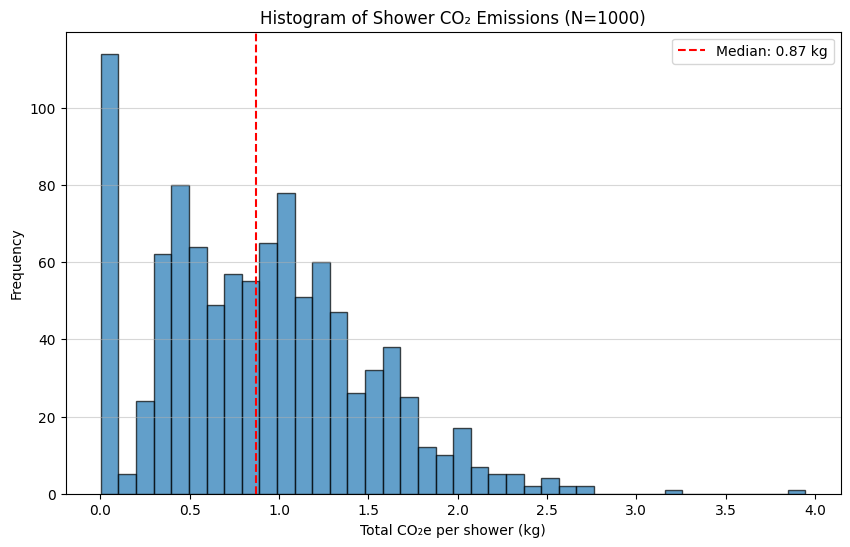

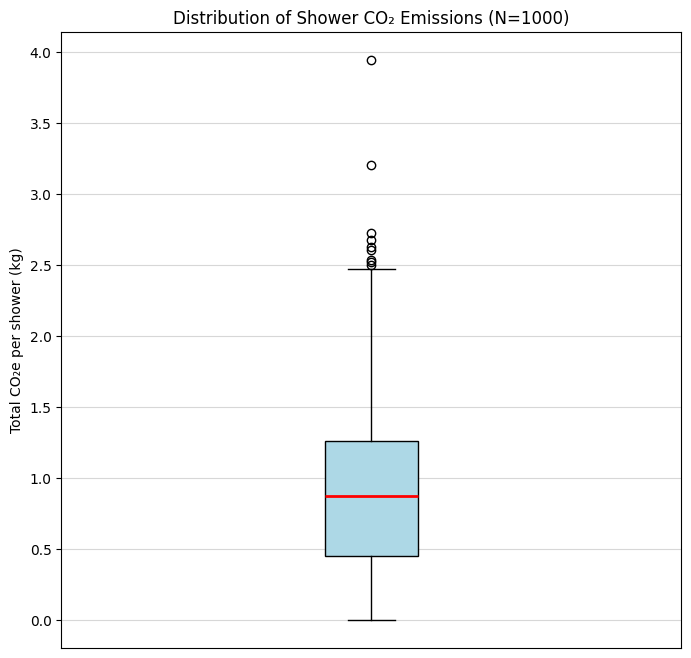

In [26]:
# Create both a histogram (to show frequency) and a box plot (to show the distribution, median, and outliers)

# 7a. Histogram

plt.figure(figsize=(10, 6))
plt.hist(results["total_co2_kg"], bins=40, edgecolor='black', alpha=0.7)
plt.axvline(results["total_co2_kg"].median(), color='red', linestyle='--', label=f'Median: {results["total_co2_kg"].median():.2f} kg')
plt.xlabel("Total CO₂e per shower (kg)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Shower CO₂ Emissions (N={N_SIMULATIONS})")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.savefig("fairglow_monte_carlo_hist.png", dpi=150, bbox_inches="tight")
plt.show()

# 7b. Box Plot

plt.figure(figsize=(8, 8))
plt.boxplot(results["total_co2_kg"], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='black'),
            medianprops=dict(color='red', linewidth=2))
plt.ylabel("Total CO₂e per shower (kg)")
plt.title(f"Distribution of Shower CO₂ Emissions (N={N_SIMULATIONS})")
plt.xticks([])
plt.grid(axis='y', alpha=0.5)
plt.savefig("fairglow_monte_carlo_boxplot.png", dpi=150, bbox_inches="tight")
plt.show()

# **STEP 8**: SAVE AND DOWNLOAD OUTPUT FILES


In [28]:
# Save the full results and the summary table to CSV files. The image files for the plots were already saved in the previous step.

# Save data to CSV

results.to_csv("fairglow_monte_carlo_full_results.csv", index=False)
summary.to_csv("fairglow_monte_carlo_summary.csv", index=False)

print("\nOutput files saved successfully:")
print("- fairglow_monte_carlo_full_results.csv (all simulation data)")
print("- fairglow_monte_carlo_summary.csv (summary statistics)")
print("- fairglow_monte_carlo_hist.png (histogram plot)")
print("- fairglow_monte_carlo_boxplot.png (box plot)")

# Download files automatically in Colab

try:
    files.download("fairglow_monte_carlo_full_results.csv")
    files.download("fairglow_monte_carlo_summary.csv")
    files.download("fairglow_monte_carlo_hist.png")
    files.download("fairglow_monte_carlo_boxplot.png")
except NameError:
    print("\nSkipping automatic download (not in a Colab environment).")


Output files saved successfully:
- fairglow_monte_carlo_full_results.csv (all simulation data)
- fairglow_monte_carlo_summary.csv (summary statistics)
- fairglow_monte_carlo_hist.png (histogram plot)
- fairglow_monte_carlo_boxplot.png (box plot)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>